Importing necessary modules

In [6]:

import numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.optimizers.legacy import SGD
import matplotlib.pyplot as plt
import multiprocessing as mp

Reading the data from the dataset file 

In [7]:
df = pd.read_csv('nepali_sentiment_dataset.csv', nrows=5000)

# Drops all NaN from the dataframe 
df =df.dropna()

# Turns every data in label to string fro better label encoding 
df['Label'] = df['Label'].apply(lambda x: x if pd.isnull(x) else str(x))

emoji = False
lang = 'N'

# Encode sentiments to numerical values
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])


Filtering unwanted characters

In [8]:
import re 

def remove_unwanted_chars(text):
    # Remove specific unwanted characters
    unwanted_chars = '!@#$%^&*()\{\}[]\\_-+=0987654321"\'/?<>.,:;|`।~'
    cleaned_text = ''.join(char for char in text if char not in unwanted_chars)
    cleaned_text = re.sub('\s+', ' ', cleaned_text).strip()  # Remove extra whitespaces
    return cleaned_text

# Apply the remove_unwanted_chars function to your dataset
df['text'] = df['Data'].apply(remove_unwanted_chars)



Performing Lemmatization based on the language

In [9]:

from Lemmatization.lemmatizer import NepaliLemmatizer


lem = NepaliLemmatizer()


def lemmatize_eng(text):
    doc = nlp(text.lower())
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text


def lemmatize_nep(text):
    results = lem.hybrid_method(text) 
    ret_val = " ".join([result['lemma'] for result in results[0]])
    return ret_val

def parallelize_dataframe(dfa, func):
    num_processes = mp.cpu_count()
    df_split = np.array_split(dfa, num_processes)
    with mp.Pool(num_processes) as p:
        df = pd.concat(p.map(func, df_split))
    return df

def parallelize_function(df):
    df = df['text'].apply(lemmatize_nep)
    return df

if lang == 'E':
    df['ltext'] = parallelize_dataframe(df['text'], lemmatize_eng)
    
if lang == 'N':
    df['ltext'] = parallelize_dataframe(df, parallelize_function)
    


print("Lemmatized text example:\n",df['ltext'][9])



/home/cabbage/Desktop/freelance/ramesh_khadka/webimplementation/newsportal/my-env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Lemmatized text example:
 राम्रो छ फिल्म यत्तीको फिल्म नेपाल आउ नै ठूलो कुरा हो


Preparing the training data

In [47]:
import pickle

pickle.dump(df['ltext'], open('words.pk1','wb'))
pickle.dump(label_encoder, open('classes.pk1','wb'))


1840    1
2115    0
4437    0
1146    2
2486    1
       ..
4426    1
466     2
3092    2
3772    2
860     0
Name: Label, Length: 3500, dtype: int64


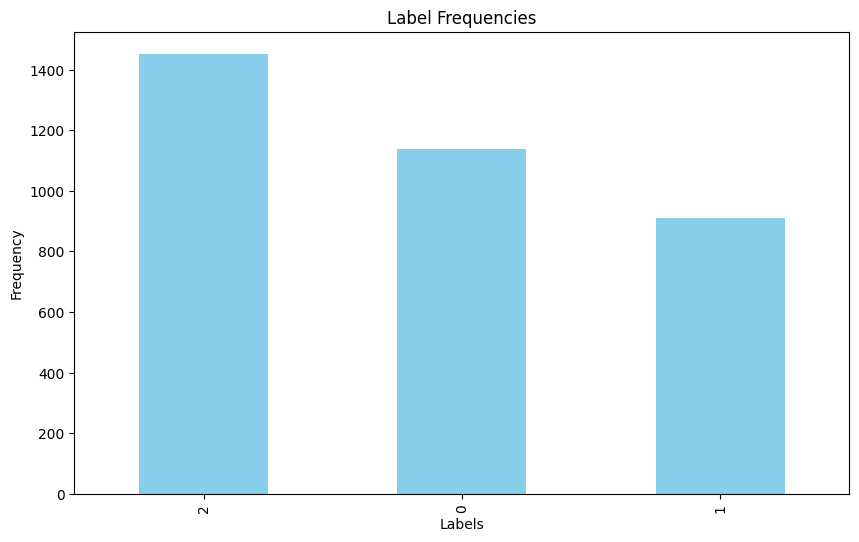

In [48]:
train_data, test_data, train_labels, test_labels = train_test_split(
    df['ltext'], df['Label'], test_size=0.3, random_state=42
)
print(train_labels)

label_counts = train_labels.value_counts()

# Plotting
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color='skyblue')
plt.title('Label Frequencies')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()

Tokenization: turning words into vector

In [49]:
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

vocab_length = len(tokenizer.word_index) + 1
train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

maxlen = 1000

train_padded = pad_sequences(train_sequences, maxlen=maxlen, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen, padding='post', truncating='post')

train_padded

array([[  14,  344,  241, ...,    0,    0,    0],
       [3940,   23,   90, ...,    0,    0,    0],
       [   2,   33,  396, ...,    0,    0,    0],
       ...,
       [1911,  678,  257, ...,    0,    0,    0],
       [8861,  160,    2, ...,    0,    0,    0],
       [  69,    3, 1656, ...,    0,    0,    0]], dtype=int32)

Setting up sequential model

In [50]:
embedding_size=32
vocab_size=vocab_length


model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=50, input_length=maxlen))
model.add(Flatten())
#model.add(LSTM(64))
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.1))
#model.add(Dense(30, activation='relu'))


model.add(Dense(3, activation='softmax')) 

Compiling the model

In [51]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])


Training the padded train data in the model

In [52]:
batch_size = 64
num_epochs = 7

hist = model.fit(train_padded, train_labels, validation_data=(test_padded, test_labels), batch_size=batch_size, epochs=num_epochs, verbose=1)

Epoch 1/7


/home/cabbage/Desktop/freelance/ramesh_khadka/webimplementation/newsportal/my-env/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


55/55 [==============================] - 2s 38ms/step - loss: 1.1536 - accuracy: 0.3869 - val_loss: 1.1261 - val_accuracy: 0.4307
Epoch 2/7
55/55 [==============================] - 2s 37ms/step - loss: 1.0711 - accuracy: 0.4317 - val_loss: 1.0478 - val_accuracy: 0.4767
Epoch 3/7
55/55 [==============================] - 2s 36ms/step - loss: 0.9683 - accuracy: 0.5726 - val_loss: 0.9773 - val_accuracy: 0.5380
Epoch 4/7
55/55 [==============================] - 2s 37ms/step - loss: 0.7260 - accuracy: 0.7020 - val_loss: 0.8982 - val_accuracy: 0.5607
Epoch 5/7
55/55 [==============================] - 2s 36ms/step - loss: 0.4863 - accuracy: 0.8440 - val_loss: 0.8706 - val_accuracy: 0.6207
Epoch 6/7
55/55 [==============================] - 2s 37ms/step - loss: 0.3064 - accuracy: 0.9294 - val_loss: 0.8753 - val_accuracy: 0.6307
Epoch 7/7
55/55 [==============================] - 2s 36ms/step - loss: 0.1907 - accuracy: 0.9603 - val_loss: 0.9103 - val_accuracy: 0.6287


Saving Model

In [53]:
model.save('sentimentmodel.h5',hist)

/home/cabbage/Desktop/freelance/ramesh_khadka/webimplementation/newsportal/my-env/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Plotting the training data

In [54]:
plt.figure(figsize=(12, 6))

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

Loss and Accuracy analysis

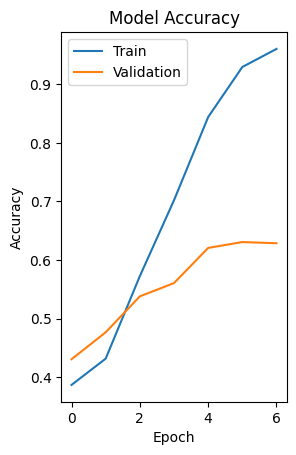

In [55]:
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

In [56]:
loss, accuracy = model.evaluate(test_padded, test_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')


47/47 [==============================] - 0s 3ms/step - loss: 0.9103 - accuracy: 0.6287
Accuracy: 62.87%


Testing the model with padded test data

In [57]:
predictions = model.predict(test_padded)

predicted_labels = [label_encoder.classes_[i] for i in predictions.argmax(axis=1)]

# Display some examples
for i in range(5):
    print(f'Text: {test_data.iloc[i]}')
    print(f'Actual Label: {label_encoder.classes_[test_labels.iloc[i]]}')
    print(f'Predicted Label: {predicted_labels[i]}')
    print('\n')




47/47 [==============================] - 0s 3ms/step
Text: मुटु चाह हो आफु त सर्प भनेपछी बाट धुवाँ निस्किन्छ
Actual Label: 0
Predicted Label: -1


Text: विश्व स्वास्थ्य संगठन डब्लुएचओ ले बिहीबार फाइजर बायोएनटेकले विकास गर् कोभिड विरुद्ध खोप आपतकालीन प्रयोग लागि अनुमति दि छ
Actual Label: 1
Predicted Label: 1


Text: संस्कृति पर्यटन तथा नागरिक उड्डयन मन्त्री भानुभक्त ढकाल कोभिड बाट मानव जीवन रक्षा गर् दायित्व निर्वाह गर् विकास निर्माण लगायत कामहरु ओझेल पर् स्वीकार गर् छन्
Actual Label: 0
Predicted Label: 1


Text: आफ्नै सुरक्षा लागित हो
Actual Label: 1
Predicted Label: 1


Text: जरिवाना तोक्
Actual Label: 1
Predicted Label: -1




Manual Testing

In [58]:
def predict_text(model, text, tokenizer):
   

    if lang == 'N':
        lemmatized_text = lemmatize_nep(text)
    elif lang == 'E':
        lemmatized_text = lemmatize_eng(text)

    text_sequence = tokenizer.texts_to_sequences([lemmatized_text])
    padded_sequence = pad_sequences(text_sequence, maxlen=maxlen, padding='post', truncating='post')
    # Make prediction
    prediction = model.predict(padded_sequence)

    # Convert prediction to class label
    a = prediction.argmax(axis=1)
    predicted_label = label_encoder.classes_[a] 
    

    return predicted_label

output = predict_text(model=model, text="रेनो अटोमोटिभले ल्यायो नयाँ अकार्षक गाडी, ‘लजी स्टेपवे रेन्ज’ अनाबरण", tokenizer=tokenizer)

print(output)

1/1 [==============================] - 0s 11ms/step
['-1']
